# Imports

In [ ]:
# !pip install keras-tuner

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperModel, HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


# Functions

In [2]:
def load_and_preprocess(data_path):
    data = pd.read_csv(data_path)
    data['temp_celsius'] = data['temp'] - 273.15
    # data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data['date'] = pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC').dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    dump(scaler_x, 'scaler.joblib')
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse



def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Data Preparation

In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/malmo_weather_five_years.csv"

# load and preprocess data
df = load_and_preprocess(data_path)
print(df.head())

# features and target
feature_columns=[col for col in df.columns if col != 'temp_celsius']
target_column='temp_celsius'

# split data by time
train_df, val_df, test_df = split_data_by_time(df, train_frac=0.7, val_frac=0.15)
print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

# scaling
train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns, target_column)

# time window
X_train, y_train, time_steps = create_timewindow(train_scaled_x, train_scaled_y, time_steps = 5)
X_val, y_val, time_steps = create_timewindow(val_scaled_x, val_scaled_y, time_steps = 5)
X_test, y_test, time_steps = create_timewindow(test_scaled_x, test_scaled_y, time_steps = 5)

input_shape = (X_train.shape[1], X_train.shape[2])

             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2019-01-01  72.583333   17.350000   45.666667  1003.958333  274.824167   
2019-01-02  49.291667   16.275000   13.000000  1021.833333  266.507500   
2019-01-03  68.208333    6.525000   58.791667  1030.000000  269.981667   
2019-01-04  86.750000    8.279167   76.250000  1019.583333  275.467083   
2019-01-05  88.916667    6.129167   53.125000  1018.291667  274.827917   

            temp_celsius  
date                      
2019-01-01      6.366250  
2019-01-02      2.090833  
2019-01-03      1.695000  
2019-01-04      4.332500  
2019-01-05      3.298750  
Train Sizes: (1278, 6) Validation Sizes: (273, 6) Test Sizes: (275, 6)


# Hyperparameter Optimization

# Build Search Space

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(LSTM(
            units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),

            return_sequences=(i < hp.Int('num_layers', 1, 5) - 1),

            kernel_regularizer=l2(hp.Float('l2_' + str(i), min_value=1e-5, max_value=1e-2, sampling='LOG')),

            kernel_initializer=hp.Choice('kernel_initializer_' + str(i), values=['glorot_uniform', 'he_uniform', 'random_normal'])
            ))

        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adamax'])

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model


# Random Search Tuner

In [9]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lstm_tuning',
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

In [10]:
random_search_tuner.search(X_train, y_train,
                           epochs=500,
                           validation_data=[X_val, y_val],
                           callbacks=[early_stopping])

Trial 20 Complete [00h 00m 11s]
val_loss: 0.4670869708061218

Best val_loss So Far: 0.0035365233197808266
Total elapsed time: 00h 20m 16s


In [ ]:
random_search_tuner.results_summary()

# Best Hyperparameter

In [19]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

In [20]:
print_hyperparameters(best_hps.values)

         Hyperparameter           Value
0            num_layers               1
1               units_0             480
2                  l2_0        0.000017
3  kernel_initializer_0  glorot_uniform
4             dropout_0             0.3
5             optimizer            adam
6         learning_rate        0.000474


In [21]:
dump(best_hps, 'best_hps_lstm.joblib')

['best_hps_lstm.joblib']

# Best Model

In [22]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]

In [23]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 480)               933120    
                                                                 
 batch_normalization (Batch  (None, 480)               1920      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 1)                 481       
                                                                 
Total params: 935521 (3.57 MB)
Trainable params: 934561 (3.57 MB)
Non-trainable params: 960 (3.75 KB)
_________________________________________________________________


# Model Performance

In [24]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.002944508334621787 Validation Loss: 0.0035365233197808266 Test Loss: 0.002884679939597845


In [ ]:
# RNN                Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM               Train Loss: 0.006593023426830769  Validation Loss: 0.009657926857471466  Test Loss: 0.010498634539544582
# LSTM 5 years       Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# 5 years LSTM hyper Train Loss: 0.002944508334621787  Validation Loss:  0.0035365233197808266  Test Loss: 0.002884679939597845


In [26]:
best_model.save('weather_forecast_lstm_tuned.keras')

In [27]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.681002524055421 Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968


In [ ]:
# 1 year  RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# 1 year  LSTM       Train MSE: 1.8786815583616459 Validation MSE: 3.4721521983793577 Test MSE: 3.7493275305443294
# 5 years LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# 5 years LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968

<Figure size 1280x960 with 0 Axes>

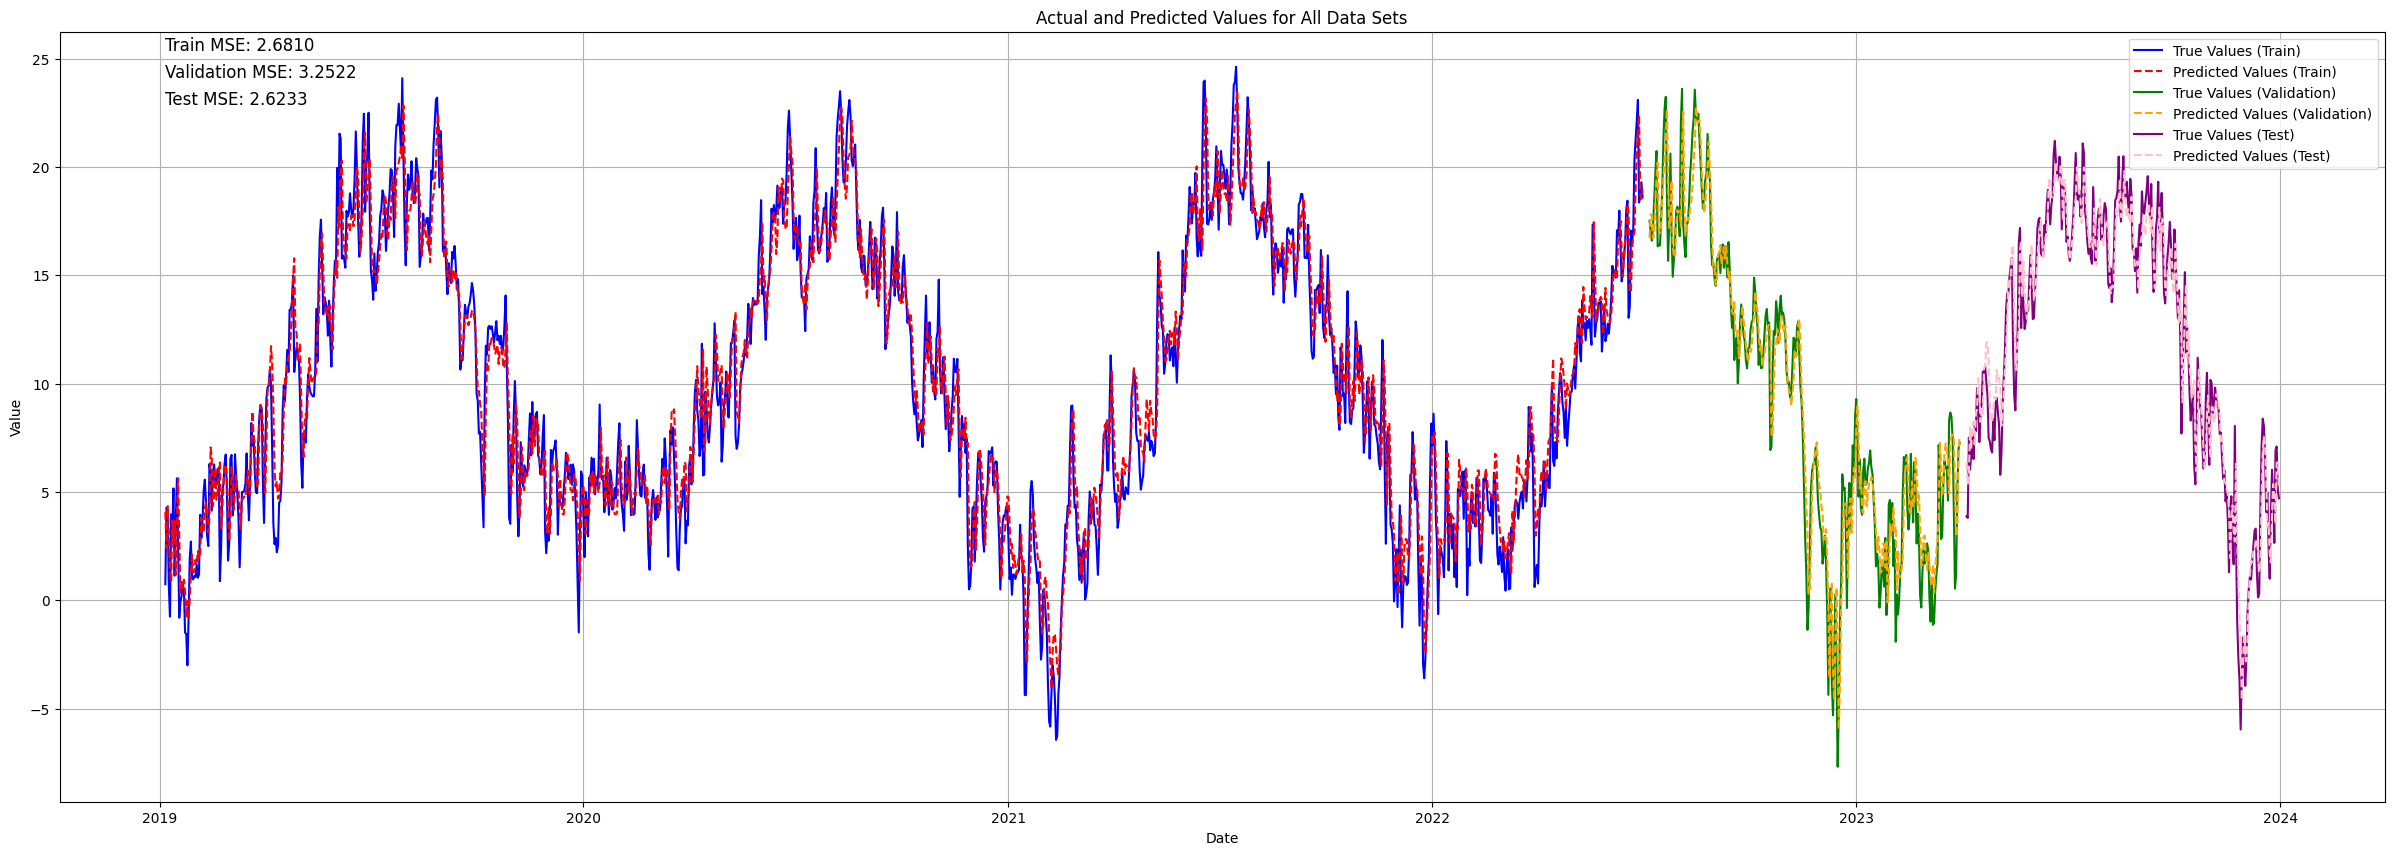

In [28]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)